In [1]:
! pip install torchdiffeq

In [1]:
import sys
sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import models.stribor_lib as st
import torch
import numpy as np
from tqdm import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/torch-mps/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set flow models for jets

In [3]:
device = 'cpu'  # ['cuda', 'cpu', or 'mps']

## Define set flow model

Load model from https://arxiv.org/abs/2010.03242

In [163]:
def get_exact_model(dim, hidden_dims, latent_dim, context_dim=0, n_transforms=4, set_data=False, device='mps', atol=1e-4):
    
    has_latent = True if context_dim > 0 else False
    
    transforms = []
    
    for _ in range(n_transforms):
        transforms.append(st.ContinuousNormalizingFlow(dim, net=st.net.DiffeqExactTraceDeepSet(dim, hidden_dims, dim, d_h=latent_dim, latent_dim=context_dim).to(device),
                                            divergence='exact', solver='dopri5', atol=atol, has_latent=has_latent, set_data=set_data).to(device))
        
    model = st.Flow(st.Normal(torch.zeros(dim).to(device), torch.ones(dim).to(device)), transforms).to(device)
    
    return model

## Basic tests with conditioning context

In [164]:
dim = 5
context_dim = 15

In [165]:
model = get_exact_model(dim=dim, hidden_dims=[64, 64], latent_dim=4, context_dim=context_dim, n_transforms=2, 
                        set_data=True, device=device)

In [166]:
context = torch.rand(8, context_dim)
context = context.unsqueeze(-2).repeat_interleave(2, dim=-2).to(device)  # Replicate context over particle dimension

x = torch.rand(8, 2, dim).to(device)

y, ldj = model(x, latent=context)

In [167]:
model.log_prob(x, latent=context).sum()

tensor(-82.9899, grad_fn=<SumBackward0>)

In [168]:
# Test permutation invariance
model.log_prob(torch.flip(x, [-2]), latent=context).sum()

tensor(-82.9899, grad_fn=<SumBackward0>)

## Variable-sized data and masking

In [169]:
dim = 5  # Dim of density per object to be modeled
context_dim = 2  # Context
obj_dim_max = 10  # Max number of objects

In [170]:
lens = torch.randint(0, obj_dim_max, [8]).to(torch.float32)
mask = (torch.arange(obj_dim_max).expand(len(lens), obj_dim_max) < torch.Tensor(lens)[:,None]).float()
mask = mask.unsqueeze(-1).to(device)

In [171]:
mask.shape

torch.Size([8, 10, 1])

In [172]:
model = get_exact_model(dim=dim, hidden_dims=[64, 64], latent_dim=4, context_dim=context_dim, n_transforms=2, 
                        set_data=True, device=device)

In [173]:
context = torch.rand(8, context_dim)
context = context.unsqueeze(-2).repeat_interleave(obj_dim_max, dim=-2).to(device)

x = torch.rand(8, obj_dim_max, dim).to(device)

y, ldj = model(x, latent=context, mask=mask)

In [174]:
# Flip mask as well as object order
model.log_prob(x, latent=context, mask=mask).sum(), model.log_prob(torch.flip(x, [-2]), latent=context, mask=torch.flip(mask, [-2])).sum()

(tensor(-385.8177, grad_fn=<SumBackward0>),
 tensor(-385.8177, grad_fn=<SumBackward0>))

## Jets

In [175]:
# Data from https://zenodo.org/record/4834876#.Y0UkO-xBzzc
q_jets = np.genfromtxt("../data/q_jets.csv")

In [185]:
from einops import rearrange

q_jets_rearranged = rearrange(q_jets, "N (particles properties) -> N particles properties", particles=30)

In [186]:
model = get_exact_model(dim=3, hidden_dims=[64, 64], latent_dim=8, context_dim=0, n_transforms=3, 
                        set_data=True, device=device, atol=1e-4)

In [194]:
x = torch.Tensor(q_jets_rearranged[:, :, :3]).to(device)
mask = torch.Tensor(q_jets_rearranged[:, :, 3:]).to(device)

mask[mask > 0] = 1
mask[mask < 0] = 0

In [195]:
x.shape

torch.Size([170679, 30, 3])

In [196]:
model.log_prob(torch.Tensor(x[:64]), mask=mask[:64]).sum()  # Test

tensor(-3753.4368, grad_fn=<SumBackward0>)

In [197]:
def train_flow(dataset, mask, params, batch_size=64, n_steps=512, lr=1e-3):
    """ Convenience function for training the normalizing flow transformation
    """
    optimizer = torch.optim.Adam(params, lr=lr)
    
    # Run specified number of optimization steps
    for i_step in tqdm(range(n_steps)):
        
        optimizer.zero_grad()
        
        # Draw random batches and compute their log-probability
        idxs = torch.Tensor(np.random.choice(dataset.shape[0], batch_size)).to(torch.int64)
        
        dataset_batch = dataset[idxs,:]
        mask_batch = mask[idxs,:]
        
        loss = -model.log_prob(dataset_batch).mean()
        
        loss.backward()
        optimizer.step()

        if i_step % 10 == 0: print('Step: {}; Loss: {}'.format(i_step, loss.item()))

In [198]:
train_flow(x, mask, model.parameters(), n_steps=200)

  0%|▎                                                                  | 1/200 [00:01<03:27,  1.04s/it]

Step: 0; Loss: 1.8632168769836426


  6%|███▋                                                              | 11/200 [00:12<03:37,  1.15s/it]

Step: 10; Loss: -2.216299533843994


 10%|██████▉                                                           | 21/200 [00:25<03:52,  1.30s/it]

Step: 20; Loss: -3.3590710163116455


 16%|██████████▏                                                       | 31/200 [00:38<03:43,  1.32s/it]

Step: 30; Loss: -3.8670945167541504


 20%|█████████████▌                                                    | 41/200 [00:51<03:25,  1.29s/it]

Step: 40; Loss: -3.702096700668335


 26%|████████████████▊                                                 | 51/200 [01:03<03:11,  1.29s/it]

Step: 50; Loss: -3.4298975467681885


 30%|████████████████████▏                                             | 61/200 [01:16<02:59,  1.29s/it]

Step: 60; Loss: -4.121940612792969


 36%|███████████████████████▍                                          | 71/200 [01:29<02:47,  1.30s/it]

Step: 70; Loss: -3.859097719192505


 40%|██████████████████████████▋                                       | 81/200 [01:43<02:41,  1.35s/it]

Step: 80; Loss: -4.326862812042236


 46%|██████████████████████████████                                    | 91/200 [01:56<02:23,  1.32s/it]

Step: 90; Loss: -4.390987873077393


 50%|████████████████████████████████▊                                | 101/200 [02:10<02:19,  1.41s/it]

Step: 100; Loss: -4.3151726722717285


 56%|████████████████████████████████████                             | 111/200 [02:24<02:03,  1.39s/it]

Step: 110; Loss: -4.692993640899658


 60%|███████████████████████████████████████▎                         | 121/200 [02:39<02:00,  1.52s/it]

Step: 120; Loss: -4.617202281951904


 66%|██████████████████████████████████████████▌                      | 131/200 [02:54<01:43,  1.50s/it]

Step: 130; Loss: -5.044852256774902


 70%|█████████████████████████████████████████████▊                   | 141/200 [03:10<01:34,  1.61s/it]

Step: 140; Loss: -4.985491752624512


 76%|█████████████████████████████████████████████████                | 151/200 [03:26<01:19,  1.63s/it]

Step: 150; Loss: -5.268863201141357


 80%|████████████████████████████████████████████████████▎            | 161/200 [03:42<01:02,  1.60s/it]

Step: 160; Loss: -5.206701755523682


 86%|███████████████████████████████████████████████████████▌         | 171/200 [03:59<00:47,  1.65s/it]

Step: 170; Loss: -5.464588642120361


 90%|██████████████████████████████████████████████████████████▊      | 181/200 [04:15<00:30,  1.63s/it]

Step: 180; Loss: -5.401932716369629


 96%|██████████████████████████████████████████████████████████████   | 191/200 [04:33<00:16,  1.79s/it]

Step: 190; Loss: -5.430305480957031


100%|█████████████████████████████████████████████████████████████████| 200/200 [04:49<00:00,  1.45s/it]


In [221]:
# Get cardinality distribution from training data
unique, counts = np.unique((mask[:, :, -1].sum(-1)), return_counts=True)  

100%|███████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.80it/s]


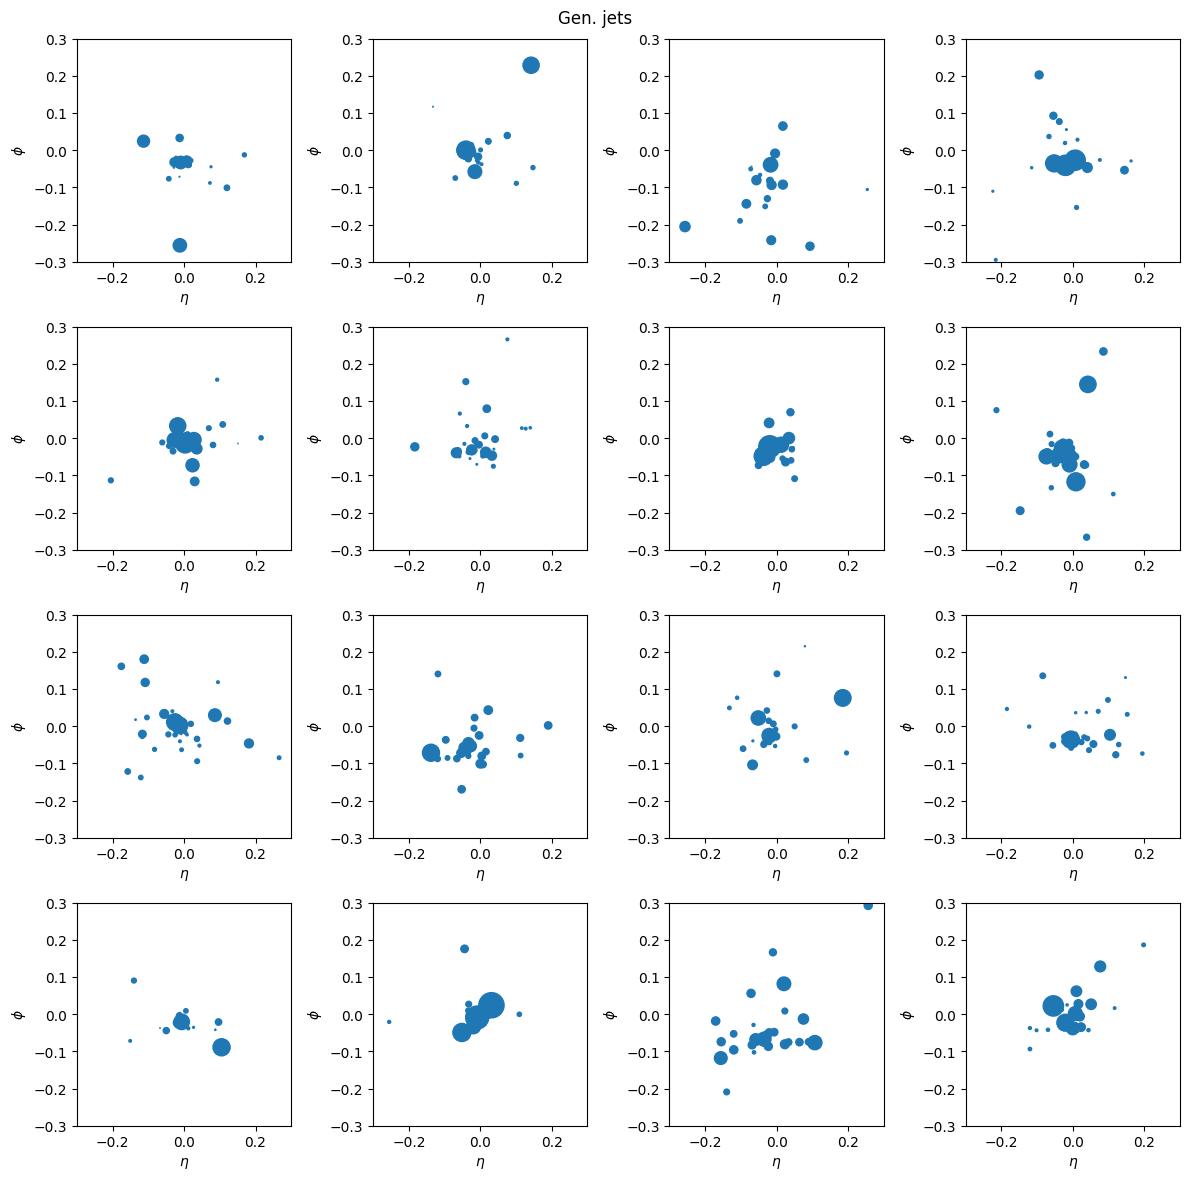

In [224]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])

    n_particles = int(np.random.choice(unique, p=counts / np.sum(counts)))
    x_sample = np.array(model.sample(num_samples=(n_particles)).detach())

    ax.scatter(*x_sample[:, :2].T, s=1000 * np.abs(x_sample[:, 2]))  # Hacky np.abs!!
            
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Gen. jets")
plt.tight_layout()

100%|██████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 199.23it/s]


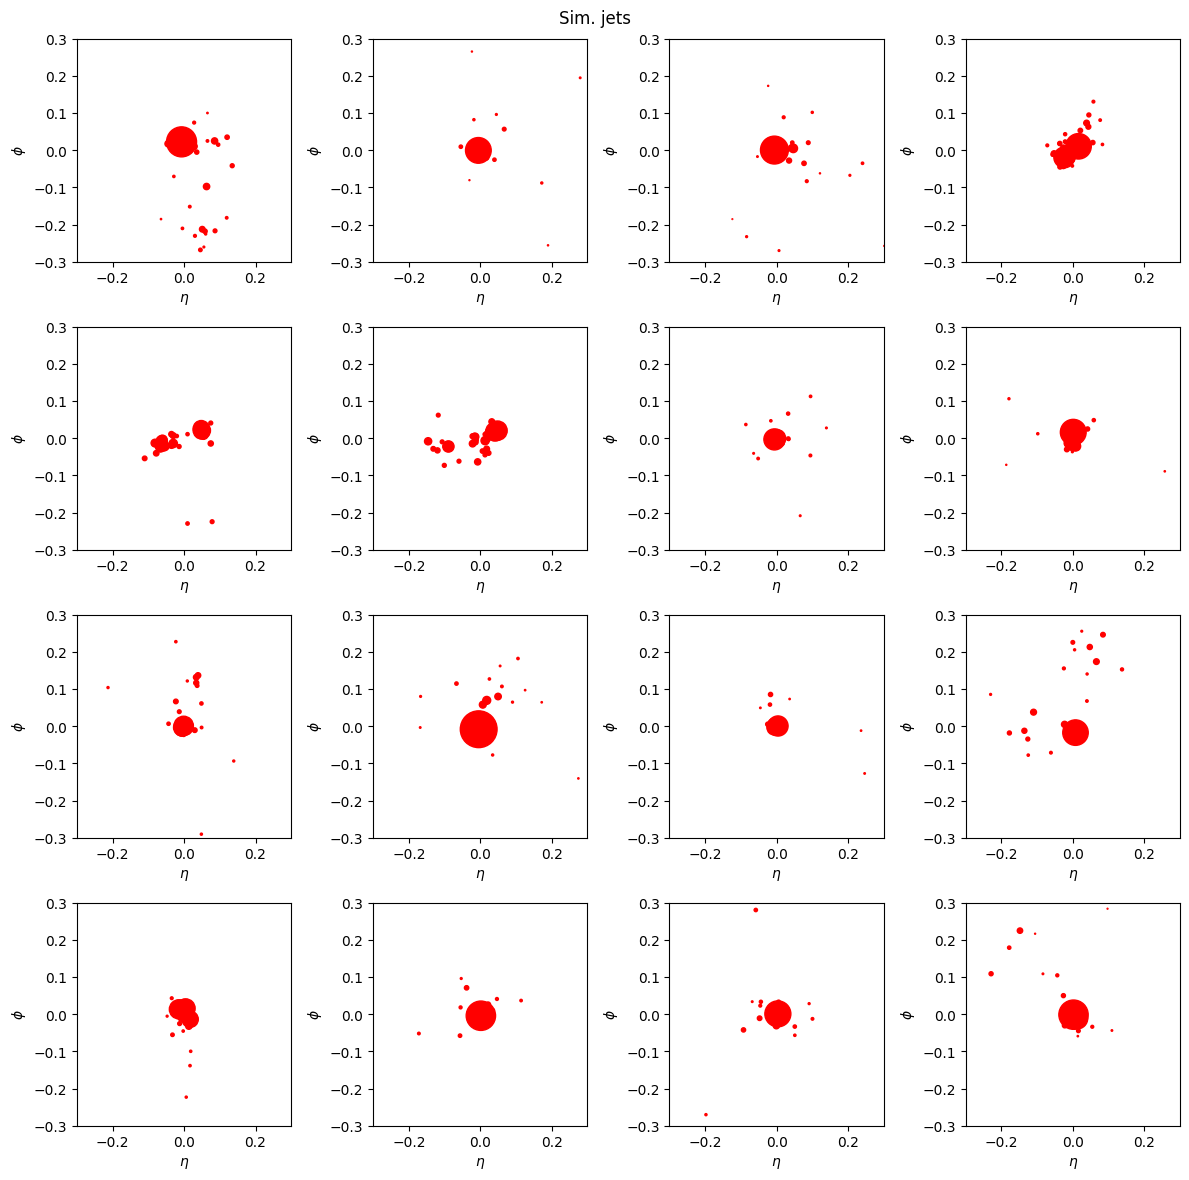

In [225]:
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 4)

for i in tqdm(range(16)):
    
    ax = fig.add_subplot(gs[i])

    x_plot = x[i, :, :2]
    s_plot = np.abs(x[i, :, 2])
    s_plot[mask[i, :, 0] < 0.] = 0.

    ax.scatter(*x_plot.T, s=1000 * s_plot, color='red')    
        
    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    
    ax.set_xlim(-0.3, 0.3)
    ax.set_ylim(-0.3, 0.3)
    
plt.suptitle("Sim. jets")
plt.tight_layout()